In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
   filter(Measurement.date >= one_year_ago).\
   order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns =['Date', 'Precipitation'])
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(prcp_df["Date"],prcp_df["Precipitation"])

plt.yticks(size= 10)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.set_title("Precipitation in Hawaii")

plt.legend(["Precipitation"],loc= 'best')
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
   group_by(Measurement.station).\
   order_by((func.count(Measurement.station)).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_id = session.query(Measurement.station,\
                           func.min(Measurement.tobs),\
                           func.max(Measurement.tobs),\
                           func.avg(Measurement.tobs)).group_by(Measurement.station).\
                           filter(Measurement.station == 'USC00519281').all()
station_id



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_2 = session.query(Measurement.date, Measurement.tobs).\
   filter(Measurement.station == 'USC00519281').\
   filter(Measurement.date >= one_year_ago).\
   order_by(Measurement.tobs).all()


active_df = pd.DataFrame(results_2, columns =['Date', 'Temperature'])
active_df.head()

,Date,Temperature
0,2017-02-02,59.0
1,2017-02-08,59.0
2,2017-02-09,59.0
3,2017-02-03,60.0
4,2017-04-30,60.0


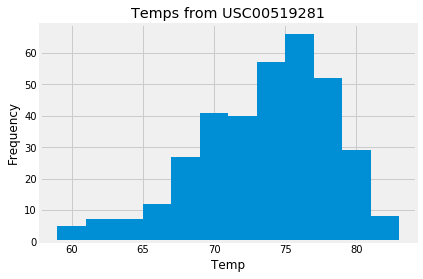

In [16]:
station_plot = active_df['Temperature'].hist(bins = 12)
station_plot.set_title('Temps from USC00519281')
station_plot.set_xlabel('Temp')
station_plot.set_ylabel('Frequency')

plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-08-10','2017-08-17')
trip

[(70.0, 78.32352941176471, 84.0)]

In [19]:
error_bar = trip[0][2] - trip[0][0]
error_bar

14.0

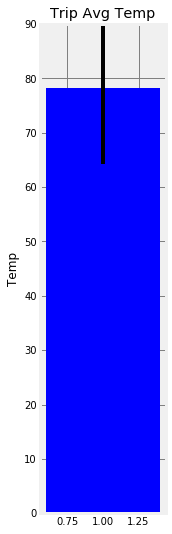

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,9))
plt.bar(1,trip[0][1], yerr=error_bar, color='blue')
plt.ylim(0,90)
plt.ylabel("Temp")
plt.title("Trip Avg Temp")
plt.grid(color='gray')
plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rain = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name,\
        Station.latitude, Station.longitude, Station.elevation).\
        join(Station, Measurement.station==Station.station).\
        group_by(Measurement.station).\
        filter(Measurement.date >= '2017-08-10', Measurement.date <= '2017-08-17').\
        order_by((func.sum(Measurement.prcp)).desc()).all()
        
trip_rain

[('USC00516128',
  1.4,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.45,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  0.26,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  0.01,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
